In [50]:
import os
import sys
import logging
from tqdm import tqdm
from dotenv import load_dotenv
import requests


logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger(__name__)

class GithubAPI:
    def __init__(self, token):
        self.token = token
        self.headers = {
            "Accept": "application/vnd.github.v3+json",
            "Authorization": f"Bearer {self.token}",
            "X-Github-Api-Version": "2022-11-28",
        }
        self.base_url = "https://api.github.com/repos/apache/beam"

    def fetchData(self, suburl):
        url = f"{self.base_url}/{suburl}"
        response = requests.get(url, headers=self.headers)
        return response.json()

load_dotenv()
api = GithubAPI(os.getenv("GITHUB_TOKEN"))

logger.info("Fetching and uploading push and schedule workflow runs...")
workflow_runs = []
with open('../commit_shas.txt', 'r') as file:
    # Read all lines from the file into a list
    commit_shas = file.readlines()
for sha in tqdm(commit_shas[0:1000]):
    push_runs = api.fetchData(f"actions/runs?event=push&head_sha={sha}")
    schedule_runs = api.fetchData(f"actions/runs?event=schedule&head_sha={sha}")
    file = open("jobs_urls.txt", "a")
    for run in (push_runs['workflow_runs'] + schedule_runs['workflow_runs']):
        if run['name'] == 'Build python source distribution and wheels':
            file.write(f"{run['jobs_url']}\n")
    file.close()

  0%|          | 0/845 [00:00<?, ?it/s]

100%|██████████| 845/845 [10:44<00:00,  1.31it/s]


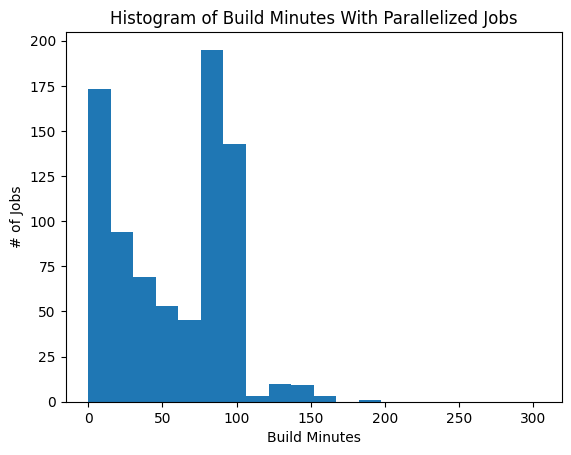

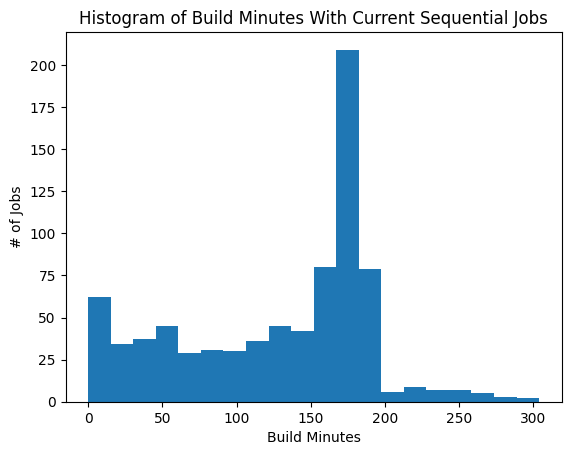

In [67]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

with open('jobs_urls.txt', 'r') as file:
    # Read all lines into a list
    jobs_urls = file.readlines()
    
load_dotenv()
api = GithubAPI(os.getenv("GITHUB_TOKEN"))

def calculate_build_mins(job):
    start = job['started_at']
    complete = job['completed_at']
    timestamp1 = datetime.fromisoformat(start.replace("Z", "+00:00"))
    timestamp2 = datetime.fromisoformat(complete.replace("Z", "+00:00"))
    difference_in_minutes = (timestamp2 - timestamp1).total_seconds() / 60
    return difference_in_minutes

python_wheel_build_jobs = [
    'Build python wheels on auto for macos-latest',
    'Build python wheels on auto for windows-latest',
    'Build python wheels on aarch64 for ubuntu-latest',
    'Build python wheels on auto for ubuntu-latest'
]

parallelized_build_times = []
current_build_times = []
for jobs in tqdm(jobs_urls):
    sub_url = jobs.split('https://api.github.com/repos/apache/beam/')[1].rstrip('\n')
    run = api.fetchData(sub_url)
    python_wheel_build_job_mins = []
    for job in run['jobs']:
        if job['name'] in python_wheel_build_jobs:
            python_wheel_build_job_mins.append(calculate_build_mins(job))
    if python_wheel_build_job_mins:
        parallelized_build_time = max(python_wheel_build_job_mins)
        current_build_time = sum(python_wheel_build_job_mins)
        parallelized_build_times.append(parallelized_build_time)
        current_build_times.append(current_build_time)

hist, bins = np.histogram(parallelized_build_times, bins=20, range=(0, max(current_build_times)+1))
plt.bar(bins[:-1], hist, width=bins[1]-bins[0], align='edge')
plt.xlabel('Build Minutes')
plt.ylabel('# of Jobs')
plt.title('Histogram of Build Minutes With Parallelized Jobs')
plt.show()
hist, bins = np.histogram(current_build_times, bins=20, range=(0, max(current_build_times)+1))
plt.bar(bins[:-1], hist, width=bins[1]-bins[0], align='edge')
plt.xlabel('Build Minutes')
plt.ylabel('# of Jobs')
plt.title('Histogram of Build Minutes With Current Sequential Jobs')
plt.show()


In [70]:
print(parallelized_build_times)
print(current_build_times)

mean_value = np.mean(parallelized_build_times)
std_deviation = np.std(parallelized_build_times)

print(f"Mean: {mean_value}")
print(f"Standard Deviation: {std_deviation}")

mean_value = np.mean(current_build_times)
std_deviation = np.std(current_build_times)

print(f"Mean: {mean_value}")
print(f"Standard Deviation: {std_deviation}")

[13.05, 39.666666666666664, 34.68333333333333, 4.216666666666667, 89.66666666666667, 90.08333333333333, 87.41666666666667, 13.85, 43.61666666666667, 67.73333333333333, 70.51666666666667, 45.53333333333333, 9.15, 95.56666666666666, 44.1, 89.06666666666666, 66.71666666666667, 89.78333333333333, 10.45, 38.8, 14.866666666666667, 4.233333333333333, 90.53333333333333, 89.43333333333334, 33.38333333333333, 89.11666666666666, 91.85, 8.616666666666667, 48.31666666666667, 130.0, 0.4666666666666667, 93.36666666666666, 35.95, 88.38333333333334, 93.71666666666667, 88.73333333333333, 22.383333333333333, 15.816666666666666, 45.516666666666666, 13.516666666666667, 99.3, 126.3, 40.016666666666666, 92.53333333333333, 89.85, 10.65, 24.083333333333332, 30.5, 1.1666666666666667, 44.68333333333333, 92.8, 89.3, 93.83333333333333, 19.866666666666667, 15.216666666666667, 4.9, 13.116666666666667, 96.6, 89.08333333333333, 65.06666666666666, 19.183333333333334, 94.28333333333333, 89.35, 90.26666666666667, 2.11666

In [71]:
from scipy.stats import kstest

ks_statistic, p_value = kstest(parallelized_build_times, current_build_times)

print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Reject null hypothesis: Distributions are significantly different.")
else:
    print("Fail to reject null hypothesis: Distributions are not significantly different.")

KS Statistic: 0.6466165413533834
P-value: 1.6240583186800187e-157
Reject null hypothesis: Distributions are significantly different.
